In [1]:
from utils import rhcalc
from ann import open_case
import numpy as np
import torch

In [2]:
M = open_case ('M/', 'm.p')
SH = open_case ('SH/', 'sh.p')
LH = open_case ('LH/', 'lh.p')

In [3]:
M.Xscale

{'mean': tensor([[6.4902e+00, 2.2342e+01, 2.1257e+01, 7.6754e+01, 1.0111e+05]]),
 'scale': tensor([[  3.0965,   6.9373,   6.8844,   8.0933, 442.8689]])}

In [10]:
def ann_flux (ux, uy, To, Ta, p, q):

    U = (ux**2 + uy**2)**0.5                   # Wind speed in m/s
    cos = ux/U
    sin = uy/U                  
    rh = rhcalc(Ta, p/100. , q)                
    
    # Reshape into sample * features ["U","tsea","tair","rh","p"]
    X = np.hstack([U.reshape(-1,1), To.reshape(-1,1), Ta.reshape(-1,1), 
                   rh.reshape(-1,1), p.reshape(-1,1)]).astype('float32')
    X = torch.tensor(X)

    # Read models
    M = open_case ('M/', 'm.p')
    SH = open_case ('SH/', 'sh.p')
    LH = open_case ('LH/', 'lh.p')
    
    # Predict fluxes
    M_mean = M.pred_mean(X)
    M_std = M.pred_var(X) ** 0.5
    SH_mean = SH.pred_mean(X)
    SH_std = SH.pred_var(X) ** 0.5
    LH_mean = LH.pred_mean(X)
    LH_std = LH.pred_var(X) ** 0.5
    
    taux = M_mean.detach().numpy().squeeze() * cos
    tauy = M_mean.detach().numpy().squeeze() * sin
    Qs = SH_mean.detach().numpy().squeeze()
    Ql = LH_mean.detach().numpy().squeeze()
    
    return taux, tauy, Qs, Ql

In [ ]:
# Path (requires that the ows_papa/ directory exists)
from mlflux.gotm import read2010
import xarray as xr

path = '../gotm/ows_papa/'
df = read2010(path, datetimeformat='%Y-%m-%d %H:%M:%S')

# Interpolate to hourly
df_ = df.set_index('datetime')
ds = xr.Dataset.from_dataframe(df_)
ds_uniform = ds.resample(datetime='H').interpolate('linear') # Interpolation non-uniform to hourly

# Select a range of dates
sd = '2012-01-01'; ed = '2012-12-30'
# sd = '2012-05-21'; ed = '2012-08-20'
# sd = '2012-08-21'; ed = '2013-01-10'
ds = ds_uniform.sel(datetime=slice(sd,ed))

ds = ds.resample(datetime='3H').mean() # Coarsening to 3-hourly

''' These are artificially assigned, for models that use these features. '''
ds['zu'] = 10*ds['U']/ds['U']
ds['zt'] = 10*ds['U']/ds['U']
ds['zq'] = 10*ds['U']/ds['U']
ds = ds.rename({'t': 'tair', 'sst': 'tsea', 'q':'qair'})

In [11]:
ds

<xarray.Dataset>
Dimensions:   (datetime: 2920)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2012-01-01 ... 2012-12-30T21:00:00
Data variables: (12/18)
    tsea      (datetime) float64 6.588 6.593 6.584 6.582 ... 5.492 5.488 5.493
    ux        (datetime) float64 6.329 2.004 -0.5152 1.423 ... 5.241 2.02 2.354
    uy        (datetime) float64 -1.742 -5.632 -8.467 ... 7.079 7.575 9.552
    tair      (datetime) float64 4.804 4.773 5.008 5.107 ... 6.131 6.058 6.21
    p         (datetime) float64 9.891e+04 9.885e+04 ... 1.002e+05 1.004e+05
    qair      (datetime) float64 0.00457 0.004589 0.004768 ... 0.005361 0.005426
    ...        ...
    rh        (datetime) float64 83.88 84.35 85.99 89.04 ... 89.1 91.31 91.63
    cos       (datetime) float64 0.9483 0.3285 -0.06174 ... 0.592 0.2614 0.2376
    sin       (datetime) float64 -0.2767 -0.9047 -0.9978 ... 0.8027 0.961 0.9698
    zu        (datetime) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
    zt        (datetime) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
    zq        (datetime) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0

In [13]:
taux, tauy, Qs, Ql = ann_flux(ds['ux'].values, ds['uy'].values, ds['tsea'].values, ds['tair'].values, ds['p'].values, ds['qair'].values)

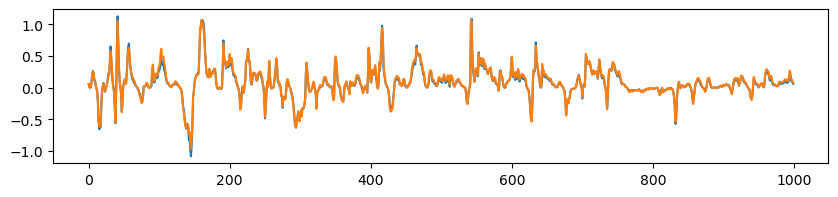

In [29]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=[10,2])
plt.plot(taux[0:1000], label='ANN')
plt.plot(ds.taux.values[0:1000], label='COARE')

(0.0, 1000.0)

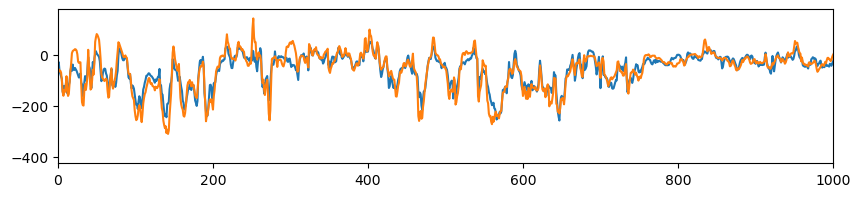

In [31]:
fig = plt.figure(figsize=[10,2])
plt.plot(Qs+Ql, label='ANN')
plt.plot(ds.Q.values-ds.lwr, label='COARE')
plt.xlim([0,1000])